Realizare decompoziție ETS...


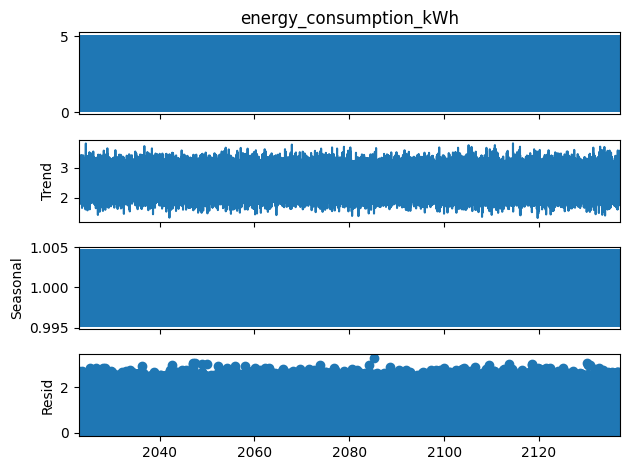

Executare test ADF...
ADF Statistic: -140.39180949605918
P-value: 0.0
Critical Values:
   1%: -3.4306770233281947
   5%: -2.861684532817176
   10%: -2.5668469308693944
Seria este staționară. Nu este necesară diferențiere.
Rulare Auto ARIMA...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=21.66 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=17630.236, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=17631.599, Time=6.22 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=17631.597, Time=2.03 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=24947.679, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=17631.838, Time=2.21 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=17631.847, Time=0.93 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=5.94 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=17629.931, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=17631.606, Time=2.84 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=in

C:\Users\flory\AppData\Local\Temp\ipykernel_2664\2967458014.py:85: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='H')[1:]


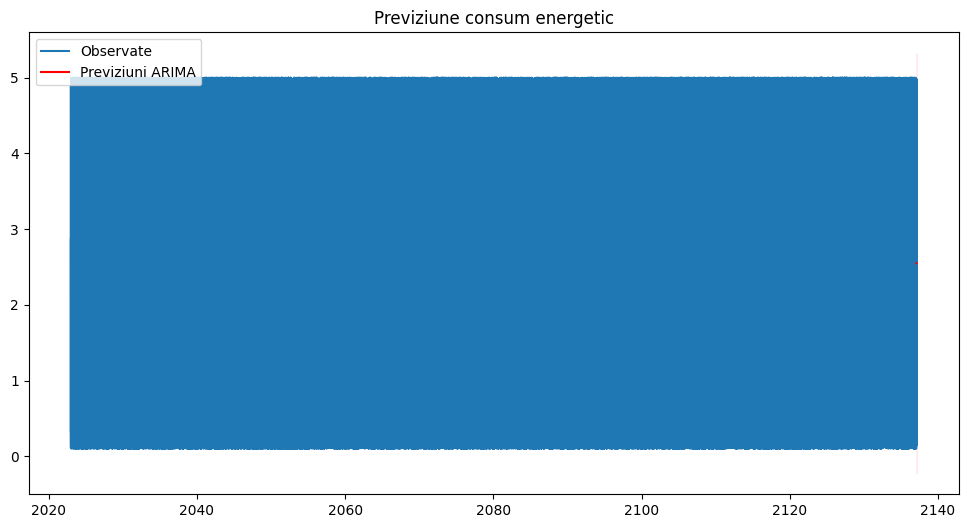

Executare clasificare cu arbore de decizie...
Acuratețea modelului: 50.04%


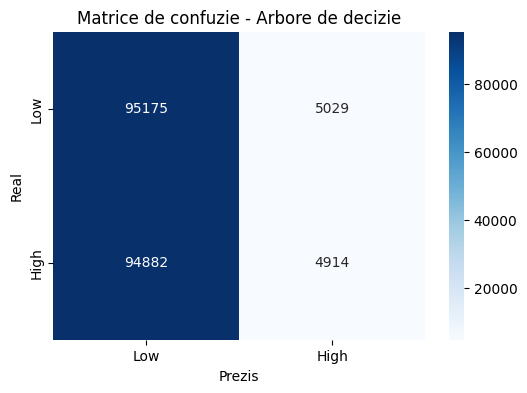

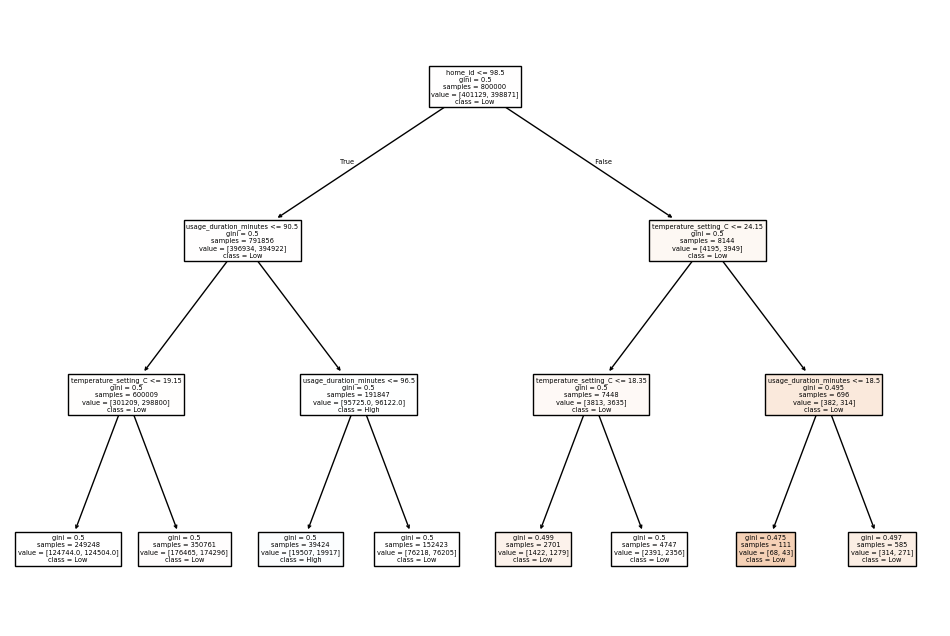

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

# 1. Încărcarea dataset-ului
file_path = "C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv"

try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Eroare: Fișierul nu a fost găsit la {file_path}. Verifică locația fișierului.")
    exit()

# 2. Convertire timestamp și sortare
df["timestamp"] = pd.to_datetime(df["timestamp"], errors='coerce')
df = df.dropna(subset=["timestamp"])  # Elimină rândurile cu timestamp invalid
df = df.set_index("timestamp").sort_index()

# 3. Verificarea frecvenței seriei temporale
df = df.asfreq('h')  # Setare la date orare

# 4. Tratarea valorilor lipsă prin interpolare
value_col = "energy_consumption_kWh"
df[value_col] = df[value_col].interpolate(method='time')

# Conversia în float32 pentru a reduce memoria
df[value_col] = df[value_col].astype(np.float32)

# 5. ETS Decomposition
print("Realizare decompoziție ETS...")
result = seasonal_decompose(df[value_col], model='multiplicative', period=24)
result.plot()
plt.show()

# 6. Test ADF pentru staționaritate
print("Executare test ADF...")
try:
    sample_df = df[value_col].dropna().sample(n=min(20000, len(df)), random_state=42)
    adf_test = adfuller(sample_df, maxlag=10)

    print(f"ADF Statistic: {adf_test[0]}")
    print(f"P-value: {adf_test[1]}")
    print("Critical Values:")
    for key, value in adf_test[4].items():
        print(f"   {key}: {value}")

    if adf_test[1] > 0.05:
        print("Seria nu este staționară. Aplic diferențiere...")
        df[value_col] = df[value_col].diff().dropna()
        plt.figure(figsize=(10, 4))
        plt.plot(df[value_col], label='Seria diferențiată')
        plt.title('Serie diferențiată')
        plt.legend()
        plt.show()
    else:
        print("Seria este staționară. Nu este necesară diferențiere.")
except Exception as e:
    print(f"Eroare la testul ADF: {e}")

# 7. Auto ARIMA optimizat
print("Rulare Auto ARIMA...")
try:
    subset_df = df[value_col].dropna().iloc[:5000]  # Limitare la 5000 de observații
    auto_model = auto_arima(subset_df, seasonal=True, m=24, trace=True, stepwise=True, 
                            error_action='ignore', suppress_warnings=True, max_order=5)

    print(f"Parametri optimi: {auto_model.order} și {auto_model.seasonal_order}")

    # Aplicare model ARIMA
    arima_model = ARIMA(df[value_col], order=auto_model.order, seasonal_order=auto_model.seasonal_order)
    arima_result = arima_model.fit()
    print(arima_result.summary())

    # Predicție ARIMA
    forecast_steps = 24
    forecast = arima_result.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='H')[1:]
    forecast_series = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Vizualizare predicție
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[value_col], label='Observate')
    plt.plot(forecast_index, forecast_series, label='Previziuni ARIMA', color='red')
    plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
    plt.title('Previziune consum energetic')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"Auto ARIMA a eșuat: {e}")

# 8. Clasificare folosind arbore decizional
print("Executare clasificare cu arbore de decizie...")

# Creare variabilă țintă binară pentru consum mare vs. mic
df['high_consumption'] = (df[value_col] > df[value_col].median()).astype(int)

# Selectare caracteristici numerice
X = df.drop(columns=[value_col, 'high_consumption']).select_dtypes(include=[np.number]).fillna(0)
y = df['high_consumption']

# Împărțire în set de antrenare și testare
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Antrenare model arbore decizional cu max_depth=3
clf = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Predicții și calcul acuratețe
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Acuratețea modelului: {acc * 100:.2f}%")

# Matrice de confuzie
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Prezis')
plt.ylabel('Real')
plt.title('Matrice de confuzie - Arbore de decizie')
plt.show()

# Afișare arbore decizional
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=['Low', 'High'], filled=True)
plt.show()
